# 1. Data Packing + Positional Encoding

We implement the center padding technique, following these steps:

1. First, we obtain the image and text regions.
2. Get the rightmost index of the image region.
3. Get the leftmost index of the text region.
4. Disentangle both the image and text regions so they become standalone arrays or tensors.
5. Right pad the image region up to the index obtained in step (2).
6. Left pad the text region up to the index obtained in step (3).
7. Then, merge them back together to mimic the center-padded square/rectangle representation of the batch.

In [1]:
from configs.config_twin_tower import VLMConfig, TrainConfig, GlobalConfig
from data.processors import get_image_processor, get_tokenizer, get_image_string
from torch.utils.data import Dataset
import torch

global_cfg = GlobalConfig()
vlm_cfg = VLMConfig()
train_cfg = TrainConfig()

tokenizer = get_tokenizer(vlm_cfg.lm_tokenizer, vlm_cfg.vlm_extra_tokens, vlm_cfg.lm_chat_template)
image_processor = get_image_processor(vlm_cfg.max_img_size, vlm_cfg.vit_img_size, vlm_cfg.resize_to_max_side_len)

/Users/patrick.irawan/Desktop/twin-tower-vlm/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Resize to max side len: False


## `Dataset` implementation

In [4]:
class VQADualDataset(Dataset):
    def __init__(self, dataset, tokenizer, image_processor, mp_image_token_length):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.image_processor = image_processor
        self.mp_image_token_length = mp_image_token_length
        self.prefix_len = self._get_prefix_len()
        
    def __len__(self):
        return len(self.dataset)
    
    def _get_prefix_len(self):
        random_string_5_letters = "xzyvd"
        random_string_chat_templated = self.tokenizer.apply_chat_template(
            [{"role": "assistant", "content": random_string_5_letters}], 
            tokenize=False, 
            add_special_tokens=False
        )
        random_string_location = random_string_chat_templated.find(random_string_5_letters)
        return len(self.tokenizer.encode(random_string_chat_templated[:random_string_location]))
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        return self._process_data(item)
    
    def _process_data(self, item):
        image = item['image']
        if image.mode != 'RGB':
            image = image.convert('RGB')
            
        processed_image, splitted_image_ratio = self.image_processor(image)
        print(splitted_image_ratio)
        
        if (not hasattr(self.tokenizer, "global_image_token") and 
            splitted_image_ratio[0] * splitted_image_ratio[1] == len(processed_image) - 1):
            processed_image = processed_image[1:]
        
        image_string = get_image_string(
            self.tokenizer, 
            [splitted_image_ratio], 
            self.mp_image_token_length
        )
        
        messages = [
            {"role": "user", "content": image_string + "Describe the image."},
            {"role": "assistant", "content": item['caption']}
        ]
        
        # Prepare the FULL sequence
        input_ids, loss_mask, attention_mask = self._prepare_inputs_and_loss_mask(messages)
        
        # Find the last image token position
        image_token_id = self.tokenizer.encode(self.tokenizer.image_token, add_special_tokens=False)[0]
        last_image_token_pos = -1
        for i in range(len(input_ids) - 1, -1, -1):
            if input_ids[i] == image_token_id:
                last_image_token_pos = i
                break
        
        # If no image token found, we can't do dual tower
        if last_image_token_pos == -1:
            return None
        
        # Get labels with proper shifting for causal LM
        labels = self._get_labels(input_ids, loss_mask)
        
        return {
            "images": [processed_image],
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "last_image_token_pos": last_image_token_pos,
        }
    
    def _prepare_inputs_and_loss_mask(self, messages):
        conv_ids = self.tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_special_tokens=False,
            return_dict=True,
        )
        mask = [0] * len(conv_ids["input_ids"])

        # Locate each assistant turn and flip its mask to 1
        cursor = 0
        for msg in messages:
            segment_ids = self.tokenizer.apply_chat_template(
                [msg], tokenize=True, add_special_tokens=False
            )
            seg_len = len(segment_ids)

            if msg["role"] == "assistant":
                start = cursor + self.prefix_len
                end = cursor + seg_len
                mask[start:end] = [1] * (end - start)

            cursor += seg_len
        
        return (
            torch.tensor(conv_ids["input_ids"]), 
            torch.tensor(mask).to(torch.bool), 
            torch.tensor(conv_ids["attention_mask"])
        )
    
    def _get_labels(self, input_ids, mask):
        """Create labels with -100 for non-target positions, shifted for causal LM."""
        labels = input_ids.clone().masked_fill(~mask, -100)
        labels = labels.roll(-1)  # Shift labels for causal LM
        labels[-1] = -100  # Last token has no target
        return labels

## `Collator` Implementation

In [5]:
from data.collators import BaseCollator

class VQADualCollator(BaseCollator):
    def __init__(self, tokenizer, max_length):
        super().__init__(tokenizer)
        self.max_length = max_length
    
    def _left_pad_batch(self, batch, max_length, pad_value):
        return [torch.nn.functional.pad(seq, (max_length - len(seq), 0), value=pad_value) for seq in batch]
    
    def _right_pad_batch(self, batch, max_length, pad_value):
        return [torch.nn.functional.pad(seq, (0, max_length - len(seq)), value=pad_value) for seq in batch]

    def _split_and_center_pad(self, batch, split_points, pad_value):
        left_parts, right_parts = [], []
        max_left, max_right = 0, 0
        for seq, split in zip(batch, split_points):
            left = seq[:split]
            right = seq[split:]
            left_parts.append(left)
            right_parts.append(right)
            max_left = max(max_left, len(left))
            max_right = max(max_right, len(right))
        
        left_parts_padded = self._right_pad_batch(left_parts, max_left, pad_value)
        right_parts_padded = self._left_pad_batch(right_parts, max_right, pad_value)
        padded_batch = [torch.cat([l, r], dim=0) for l, r in zip(left_parts_padded, right_parts_padded)]

        return padded_batch, max_left

    def _center_pad_batch(self, batch, split_points):
        batch["input_ids"], max_left = self._split_and_center_pad(batch["input_ids"], split_points, self.tokenizer.pad_token_id)
        batch["attention_mask"], _ = self._split_and_center_pad(batch["attention_mask"], split_points, 0)
        batch["labels"], _ = self._split_and_center_pad(batch["labels"], split_points, -100)
        return max_left

    def _discard_samples_that_are_too_long(self, batch, split_points, max_length):
        filtered = []
        filtered_split_points = []
        for i in range(len(batch["input_ids"])):
            seq = batch["input_ids"][i]
            if len(seq) <= max_length:
                filtered.append({k: batch[k][i] for k in batch})
                filtered_split_points.append(split_points[i])
        if not filtered:
            # If everything was filtered out, return an empty dict of lists and split_points.
            return {k: [] for k in batch}, []
        # Flatten dicts-of-lists for each key
        out = {k: [d[k] for d in filtered] for k in batch}
        return out, filtered_split_points

    def prepare_batch(self, batch, max_length=None):
        # 1) Handle empty batch
        if not batch:
            return {"input_ids": [], "labels": [], "attention_mask": [], "images": [], "last_img_idx": []}
        
        # 2) Drop None rows
        batch = [s for s in batch if s is not None]
        if not batch:
            return {"input_ids": [], "labels": [], "attention_mask": [], "images": [], "last_img_idx": []}
        batch = {k: [item[k] for item in batch] for k in batch[0]}
        split_points = [int(pos.item()) + 1 if hasattr(pos, "item") else int(pos) + 1 for pos in batch["last_image_token_pos"]]

        # 3) Discard samples that are too long
        max_len = self.max_length if max_length is None else max_length
        batch, split_points = self._discard_samples_that_are_too_long(batch, split_points, max_len)

        # 4) Center pad the batch
        if not batch["input_ids"]:
            return {"input_ids": [], "labels": [], "attention_mask": [], "images": [], "last_img_idx": []}

        max_left = self._center_pad_batch(batch, split_points)

        batch_size = len(batch["input_ids"])
        seq_length = batch["input_ids"][0].shape[0]

        # Calculate last_img_idx: it's max_left - 1 (the last position before padding)
        # If max_left is 0, there's no image token, so return -1
        last_img_idx = max_left - 1 if max_left > 0 else -1

        return {
            "input_ids": torch.stack(batch["input_ids"]),
            "attention_mask": torch.stack(batch["attention_mask"]),
            "labels": torch.stack(batch["labels"]),
            "img_region_mask": torch.arange(seq_length).unsqueeze(0).expand(batch_size, -1) < max_left,
            "last_img_idx": last_img_idx,
            "images": batch["images"],
        }

    def __call__(self, batch):
        return self.prepare_batch(batch, max_length=self.max_length)

## Skippable `RoPE` Implementation

In [6]:
import torch.nn as nn

class RotaryEmbedding(nn.Module):
    """
        Compute Rotary Embedding to introduce positional dependency to input sequence without additional training parameters and 
        relative distance of token position ids through angle rotation.

        Args:
            cfg: Configuration object containing:
                - lm_hidden_dim (int): Hidden dimension size.
                - lm_n_heads (int): Number of attention heads.
                - lm_re_base (float): Base for rotary embedding frequencies.
                - lm_max_position_embeddings (int): Max sequence length supported for rotary embedding.
                - lm_attn_scaling (float): Attention scaling factor.
        """
    
    def __init__(self, cfg):
        super().__init__()
        assert cfg.lm_hidden_dim % cfg.lm_n_heads == 0, "Hidden dimension must be divisible by number of heads"
        
        self.dim = cfg.lm_hidden_dim // cfg.lm_n_heads # dim of each head
        self.base = cfg.lm_re_base
        self.max_seq_len = cfg.lm_max_position_embeddings
        # Standard RoPE implementation - create frequencies for each dimension
        # freq_i = 1 / (base^(2i/dim)) where i is the dimension index
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2).float() / self.dim))
        self.register_buffer("inv_freq", inv_freq)
        self.original_max_seq_len = cfg.lm_max_position_embeddings
        self.attention_scaling = cfg.lm_attn_scaling

    @torch.no_grad()
    def forward(self, position_ids: torch.Tensor, attention_mask: torch.Tensor = None) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Compute rotary positional embeddings (cosine and sine components).

        Args:
            position_ids (torch.Tensor): Tensor of shape (batch_size, seq_len) containing position indices.
            attention_mask (torch.Tensor, optional): Tensor of shape (batch_size, seq_len) with 1 for valid tokens, 0 for padding.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Tuple of two tensors (cos, sin), each of shape
                                  (batch_size, seq_len, dim), representing rotary embeddings.
        """

        batch_size, seq_len = position_ids.shape
        
        # If attention mask is provided, adjust position_ids to not increment for padding tokens
        if attention_mask is not None:
            position_ids = attention_mask.cumsum(dim=1) - 1
            position_ids = position_ids.masked_fill(attention_mask == 0, 0)
        
        # Dynamic scaling for longer sequences
        # Divide the angle frequency to fit more rotation into the embedding space.
        max_seq = position_ids.max() + 1
        if max_seq > self.original_max_seq_len:
            scale = max_seq / self.original_max_seq_len
            inv_freq = self.inv_freq / scale
        else:
            inv_freq = self.inv_freq
            
        # Compute theta = position * frequency
        # Flatten position_ids for batch processing
        flat_position_ids = position_ids.reshape(-1).float()
        
        # Element-wise outer product: [seq_len] x [dim/2] => [seq_len, dim/2]
        freqs = flat_position_ids.unsqueeze(-1) * inv_freq.unsqueeze(0)
        
        # Reshape to include batch dimension
        freqs = freqs.reshape(batch_size, seq_len, -1)
        
        # Now create interleaved pattern
        emb = torch.cat([freqs, freqs], dim=-1)
        
        # Compute cos and sin
        cos = torch.cos(emb) * self.attention_scaling
        sin = torch.sin(emb) * self.attention_scaling

        if attention_mask is not None:
            mask_expanded = attention_mask.unsqueeze(-1).expand_as(cos)
            cos = cos * mask_expanded.float()
            sin = sin * mask_expanded.float()
        
        return cos, sin

## Testing

In [11]:
from PIL import Image
from torch.utils.data import DataLoader

img1 = Image.open("image.png").convert("RGB")
img2 = Image.open("image2.png").convert("RGB")
img3 = Image.open("image3.png").convert("RGB")

dummy_dataset = [
    {"image": img1, "caption": "A screen of laptop"},
    {"image": img2, "caption": "What are those, is this a screen? wow its really greatsadasdasdsa?"},
    {"image": img3, "caption": "A small dog is sitting on a couch."},
    {"image": img1, "caption": "xyzd"},
    {"image": img1, "caption": "A screen of laptop"},
    {"image": img2, "caption": "What are those, is this a screen? wow its really greatsadasdasdsa?"},
    {"image": img3, "caption": "A small dog is sitting on a couch."},
    {"image": img1, "caption": "xyzd"},
]

dataset = VQADualDataset(
    dataset=dummy_dataset,
    tokenizer=tokenizer,
    image_processor=image_processor,
    mp_image_token_length=vlm_cfg.mp_image_token_length
)

collator = VQADualCollator(tokenizer, max_length=256)
loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collator
)


In [12]:
batch = next(iter(loader))

input_ids = batch['input_ids']
images = batch['images']
attention_mask = batch['attention_mask']
img_region_mask = batch['img_region_mask']
last_img_idx = batch['last_img_idx']

(1, 1)
(1, 1)
(1, 1)
(1, 1)


In [13]:
img_region_mask

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True, 

### Batching Masking Verification

In [14]:
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'img_region_mask', 'last_img_idx', 'images'])

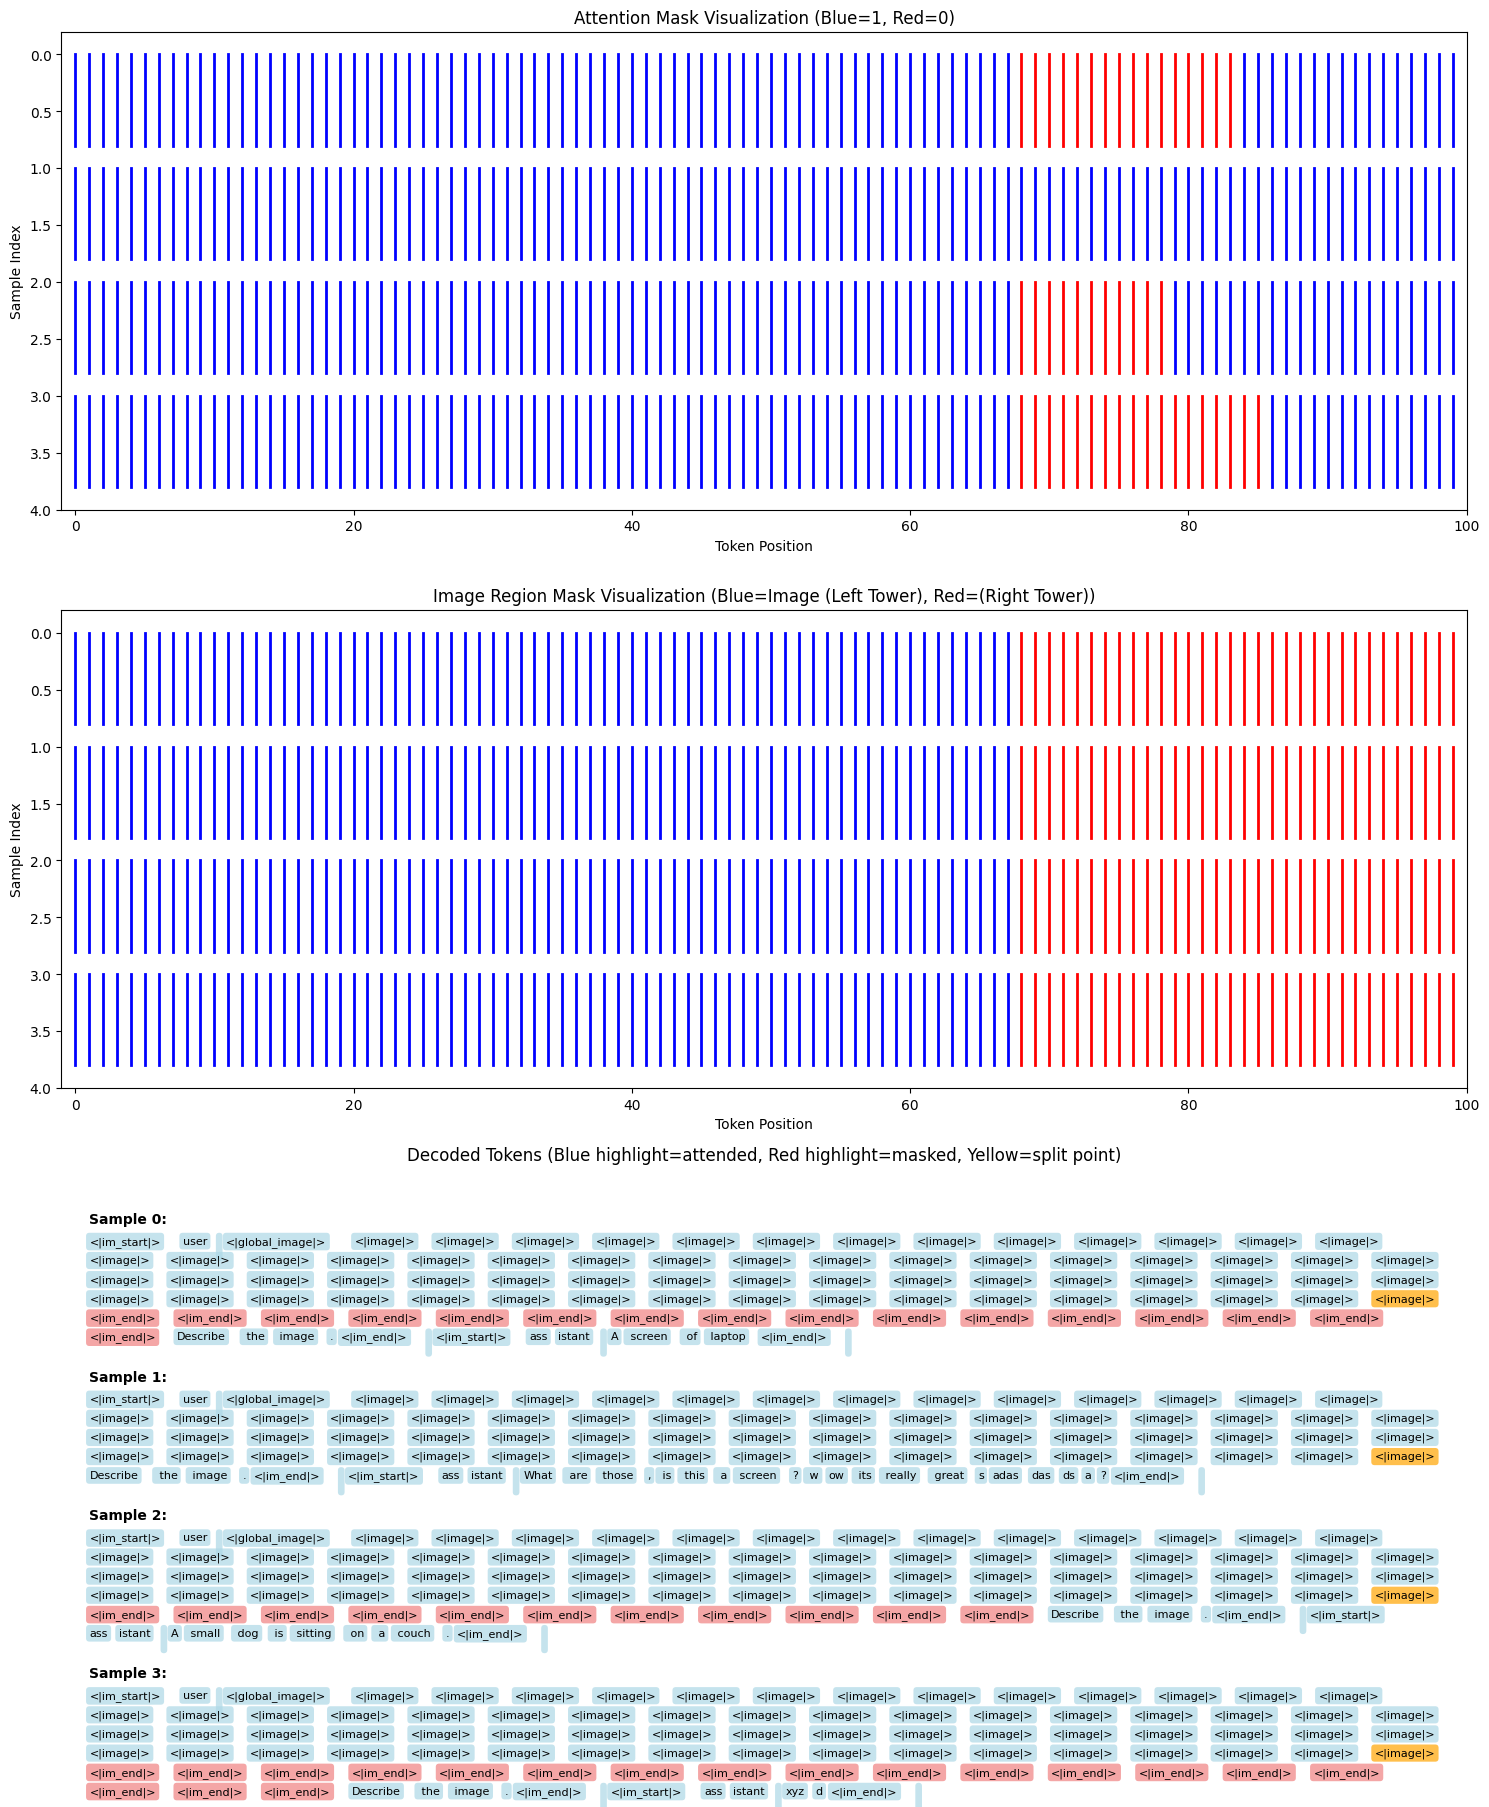

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

# Get attention mask and img_region_mask as numpy arrays
attn_mask = batch['attention_mask'].cpu().numpy()
img_region_mask = batch['img_region_mask'].cpu().numpy()
input_ids = batch['input_ids'].cpu().numpy()

# Create figure with three subplots stacked vertically
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 18))

# Plot attention mask
for i in range(attn_mask.shape[0]):
    # Create color array: blue for 1, red for 0
    colors = ['blue' if val == 1 else 'red' for val in attn_mask[i]]
    
    # Plot each position as a vertical line segment
    for j, color in enumerate(colors):
        ax1.plot([j, j], [i, i+0.8], color=color, linewidth=2)

ax1.set_xlabel('Token Position')
ax1.set_ylabel('Sample Index')
ax1.set_title('Attention Mask Visualization (Blue=1, Red=0)')
ax1.set_ylim(-0.2, attn_mask.shape[0])
ax1.set_xlim(-1, attn_mask.shape[1])
ax1.invert_yaxis()

# Plot img_region_mask
for i in range(img_region_mask.shape[0]):
    # Create color array: green for True, orange for False
    colors = ['blue' if val else 'red' for val in img_region_mask[i]]
    
    # Plot each position as a vertical line segment
    for j, color in enumerate(colors):
        ax2.plot([j, j], [i, i+0.8], color=color, linewidth=2)

ax2.set_xlabel('Token Position')
ax2.set_ylabel('Sample Index')
ax2.set_title('Image Region Mask Visualization (Blue=Image (Left Tower), Red=(Right Tower))')
ax2.set_ylim(-0.2, img_region_mask.shape[0])
ax2.set_xlim(-1, img_region_mask.shape[1])
ax2.invert_yaxis()

# Plot decoded tokens with attention mask highlighting
ax3.axis('off')
ax3.set_title('Decoded Tokens (Blue highlight=attended, Red highlight=masked, Yellow=split point)', fontsize=12, pad=20)

# Get last_img_idx for split point marking
last_img_idx = batch['last_img_idx']

y_offset = 0.95
for i in range(input_ids.shape[0]):
    # Decode the tokens for this sample
    decoded_text = tokenizer.decode(input_ids[i], skip_special_tokens=False)
    
    # Get individual tokens
    tokens = [tokenizer.decode([token_id]) for token_id in input_ids[i]]
    
    # Display sample index
    ax3.text(0.02, y_offset, f"Sample {i}:", fontsize=10, weight='bold', 
             transform=ax3.transAxes, verticalalignment='top')
    y_offset -= 0.05
    
    # Display tokens with highlighting based on attention mask
    x_pos = 0.02
    for j, token in enumerate(tokens):
        # Determine background color based on attention mask and split point
        if j == last_img_idx:
            bgcolor = 'orange'
        elif attn_mask[i][j] == 1:
            bgcolor = 'lightblue'
        else:
            bgcolor = 'lightcoral'
        
        # Add text with background color
        text = ax3.text(x_pos, y_offset, token, fontsize=8, 
                       transform=ax3.transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor=bgcolor, alpha=0.7, edgecolor='none'))
        
        # Get the width of the text to position next token
        renderer = fig.canvas.get_renderer()
        bbox = text.get_window_extent(renderer=renderer)
        bbox_transformed = bbox.transformed(ax3.transAxes.inverted())
        x_pos += bbox_transformed.width + 0.005
        
        # Wrap to next line if needed
        if x_pos > 0.95:
            x_pos = 0.02
            y_offset -= 0.04
    
    y_offset -= 0.08  # Space between samples

plt.tight_layout()
plt.show()

### Positional Embedding Verification

In [16]:
x = np.array([1,2,3,4,5])
y = np.array([1,1,1,0,0,0,1,1])
z = np.array([9,9,9,9,9,9,9,9])

# Apply x to z based on mask y (where y==1)
mask_indices = np.where(y == 1)[0]
z[mask_indices] = x

In [17]:
z

array([1, 2, 3, 9, 9, 9, 4, 5])

In [18]:
rotary_embd = RotaryEmbedding(vlm_cfg)

In [19]:
import matplotlib.pyplot as plt

def visualize_rotary_embeddings(input_ids, cos, sin, attention_mask=None, batch_idx=0):
    cos_batch = cos[batch_idx].cpu().numpy()  # Shape: [seq_len, dim]
    sin_batch = sin[batch_idx].cpu().numpy()  # Shape: [seq_len, dim]
    tokens_batch = input_ids[batch_idx]
    
    # Create figure with 4 subplots in a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot cosine embeddings heatmap
    im1 = axes[0, 0].imshow(cos_batch.T, aspect='auto', cmap='RdBu', interpolation='nearest')
    axes[0, 0].set_xlabel('Sequence Position')
    axes[0, 0].set_ylabel('Embedding Dimension')
    axes[0, 0].set_title('Cosine Rotary Embeddings (First Batch)')
    plt.colorbar(im1, ax=axes[0, 0])
    
    # Add token labels on x-axis (sample every few tokens to avoid crowding)
    step = max(1, len(tokens_batch) // 20)
    token_positions = list(range(0, len(tokens_batch), step))
    token_labels = [str(tokens_batch[i].item()) for i in token_positions]
    axes[0, 0].set_xticks(token_positions)
    axes[0, 0].set_xticklabels(token_labels, rotation=45, ha='right', fontsize=8)
    
    # Plot sine embeddings heatmap
    im2 = axes[0, 1].imshow(sin_batch.T, aspect='auto', cmap='RdBu', interpolation='nearest')
    axes[0, 1].set_xlabel('Sequence Position')
    axes[0, 1].set_ylabel('Embedding Dimension')
    axes[0, 1].set_title('Sine Rotary Embeddings (First Batch)')
    plt.colorbar(im2, ax=axes[0, 1])
    
    # Add token labels on x-axis
    axes[0, 1].set_xticks(token_positions)
    axes[0, 1].set_xticklabels(token_labels, rotation=45, ha='right', fontsize=8)
    
    # Select a few dimensions to plot
    dims_to_plot = [0, 16, 32, 48] if cos_batch.shape[1] > 48 else list(range(min(4, cos_batch.shape[1])))
    
    # Plot cosine curves for selected dimensions
    for dim in dims_to_plot:
        axes[1, 0].plot(cos_batch[:, dim], label=f'Dim {dim}', alpha=0.7)
    
    axes[1, 0].set_xlabel('Sequence Position')
    axes[1, 0].set_ylabel('Cosine Value')
    axes[1, 0].set_title('Cosine Rotary Embeddings - Selected Dimensions')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot sine curves for selected dimensions
    for dim in dims_to_plot:
        axes[1, 1].plot(sin_batch[:, dim], label=f'Dim {dim}', alpha=0.7)
    
    axes[1, 1].set_xlabel('Sequence Position')
    axes[1, 1].set_ylabel('Sine Value')
    axes[1, 1].set_title('Sine Rotary Embeddings - Selected Dimensions')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Without attention mask applied

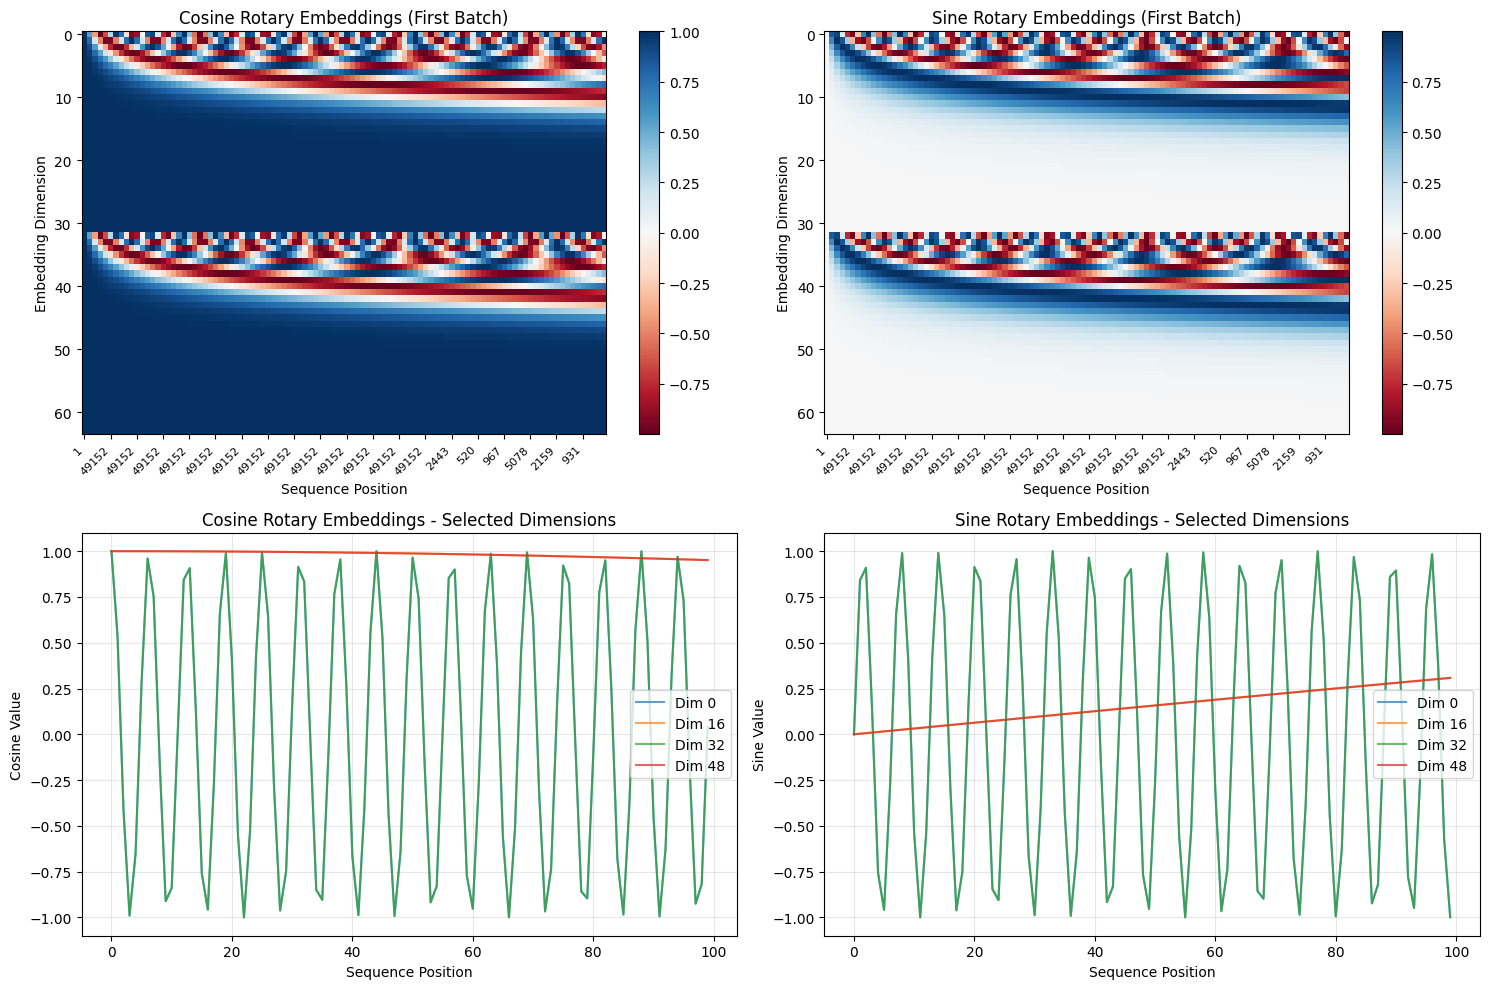

In [20]:
start_pos = 0
B, T_curr = input_ids.shape
position_ids = torch.arange(start_pos, start_pos + T_curr, device=torch.device('cpu')).unsqueeze(0).expand(B, -1)
cos, sin = rotary_embd(position_ids, attention_mask=None)
visualize_rotary_embeddings(input_ids, cos, sin, batch_idx=1)

With attention mask applied

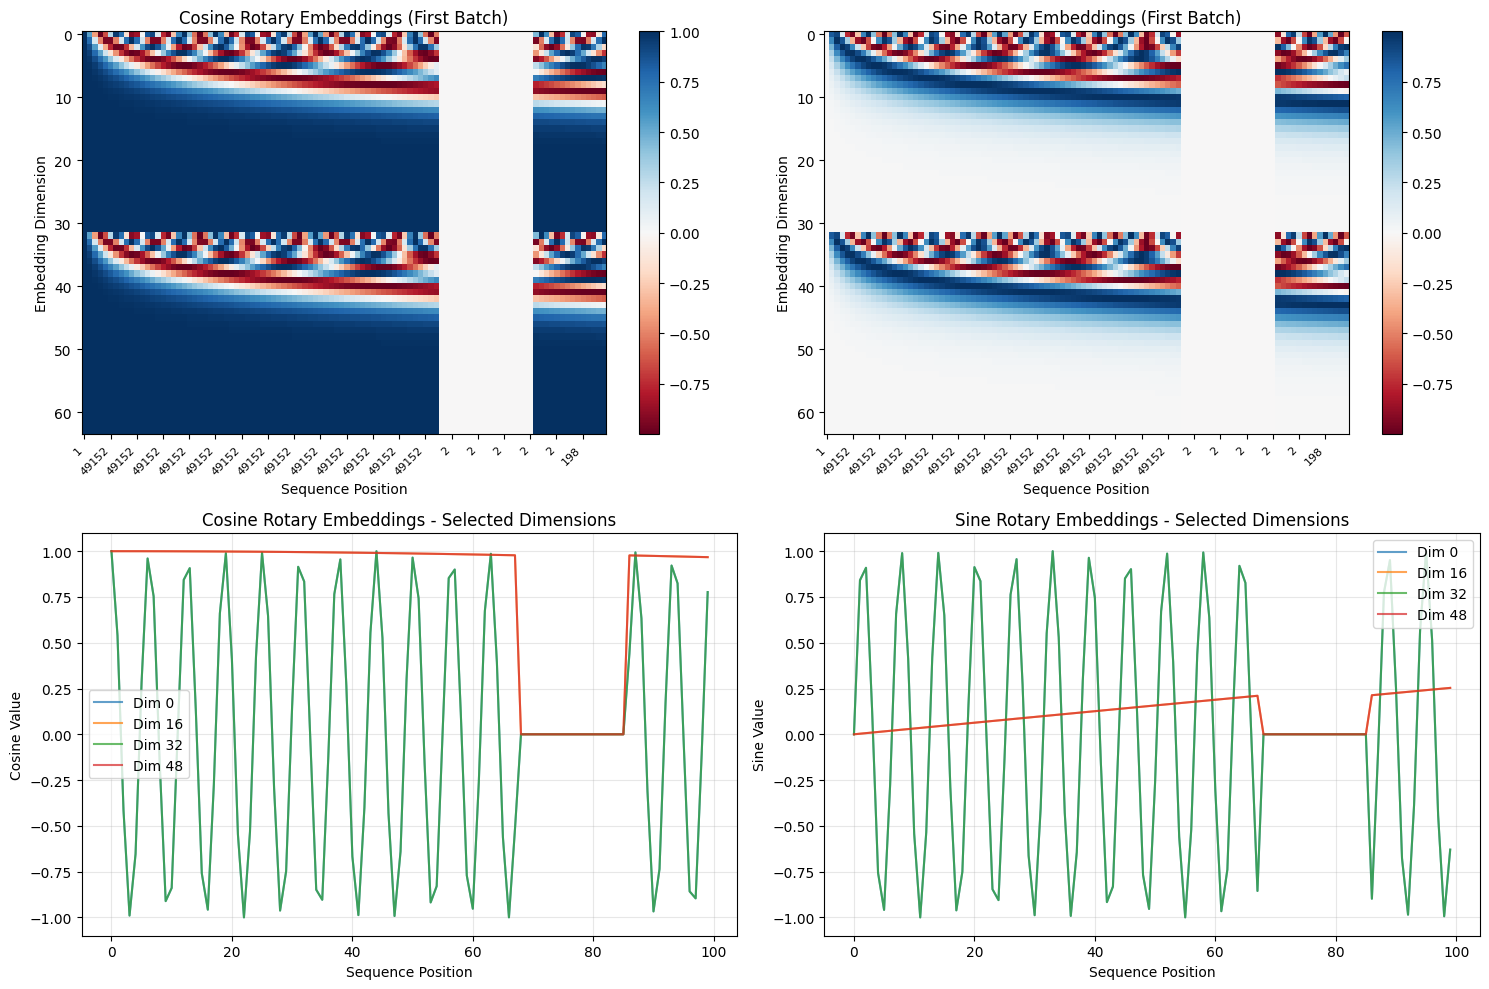

In [21]:
start_pos = 0
B, T_curr = input_ids.shape
position_ids = torch.arange(start_pos, start_pos + T_curr, device=torch.device('cpu')).unsqueeze(0).expand(B, -1)
cos, sin = rotary_embd(position_ids, attention_mask=attention_mask)
visualize_rotary_embeddings(input_ids, cos, sin, batch_idx=3)

# 2. Left Tower (Vision-only Tower)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from models.language_model import LanguageModel
from models.vision_language_model import VisionLanguageModel
from models.config import VLMConfig
from models.utils import top_k_top_p_filtering


def get_best_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')

## `LeftTower` Implementation

In [ ]:
class LeftTower(VisionLanguageModel):
    def __init__(
        self,
        cfg: VLMConfig,
        *,
        load_backbone: bool = True,
        freeze_vision_encoder: bool = False,
        freeze_modality_projector: bool = False,
        freeze_language_decoder: bool = False,
    ):
        super().__init__(cfg, load_backbone=load_backbone)
        if freeze_vision_encoder:
            for p in self.vision_encoder.parameters():
                p.requires_grad = False
        if freeze_modality_projector:
            for p in self.MP.parameters():
                p.requires_grad = False
        if freeze_language_decoder:
            for p in self.decoder.parameters():
                p.requires_grad = False

    def forward(
        self, 
        input_ids: torch.Tensor, 
        images, 
        attention_mask: torch.Tensor = None,
    ):
        images_tensor = self._process_images(images, input_ids.device)
        token_embd = self.decoder.token_embedding(input_ids)

        if images_tensor is not None:
            image_embd = self.vision_encoder(images_tensor)
            image_embd = self.MP(image_embd)
            token_embd = self._replace_img_tokens_with_embd(input_ids, token_embd, image_embd)
        
        _, kv_cache = self.decoder(token_embd, attention_mask=attention_mask)
        
        return None, kv_cache

## `kv_cache` testing

In [138]:
left_tower = LeftTower(vlm_cfg)

Loading from backbone weights
Successfully loaded google/siglip2-base-patch16-512 weights from safetensors. Model has 86,433,024 parameters.
Extending token embeddings from torch.Size([49152, 576]) to torch.Size([49218, 576])
Initialized 66 new token embeddings
Successfully loaded HuggingFaceTB/SmolLM2-135M-Instruct weights from safetensors. Model has 134,553,024 parameters.


Cut to just get the left tower's input 9up to `last_img_idx`

In [139]:
if not isinstance(input_ids, torch.Tensor):
    input_ids = torch.tensor(input_ids)

left_input_ids = input_ids[:, :last_img_idx + 1]
left_attention_mask = attention_mask[:, :last_img_idx + 1]

Get the `img_kv_cache` (or left tower's `kv_cache`)

In [140]:
_, img_kv_cache = left_tower.forward(left_input_ids, images, left_attention_mask)

Verify the shape to only capture up to the image only

In [143]:
len(img_kv_cache)

30

In [141]:
img_kv_cache[0]['key'].shape

torch.Size([4, 3, 68, 64])

In [142]:
img_kv_cache

[{'key': tensor([[[[-3.1820,  0.1983, -0.5812,  ..., -1.1707,  2.9761,  0.3053],
            [-0.4471,  0.3018, -0.5462,  ..., -0.3952,  1.6823, -0.0997],
            [ 0.3911, -1.1132,  0.5346,  ..., -1.4242,  0.8315,  0.1673],
            ...,
            [-0.8822,  0.6291, -0.1369,  ..., -0.4769, -0.0448,  0.5099],
            [-0.4621,  0.8035, -0.1152,  ..., -0.4769, -0.0448,  0.5099],
            [ 0.3828,  0.6022, -0.0667,  ..., -0.4769, -0.0448,  0.5098]],
  
           [[-0.0752, -1.5745,  0.9895,  ..., -0.6411,  0.2732,  0.4545],
            [ 1.6971, -0.3020,  0.0942,  ..., -0.2997, -0.1043,  0.6907],
            [ 4.1027,  2.7697, -0.7573,  ..., -0.2919, -0.5373,  1.3986],
            ...,
            [-1.9317, -0.0923, -0.3447,  ..., -0.0276,  0.3160,  0.3605],
            [-0.4451, -0.3728, -0.0131,  ..., -0.0276,  0.3160,  0.3605],
            [ 1.4507, -0.4790,  0.3217,  ..., -0.0276,  0.3160,  0.3605]],
  
           [[-1.6773, -0.3353, -0.8107,  ...,  1.6619,  0.5020,

# 3. Right Tower (Text-only tower)

## `GroupedQueryAttention`'s `forward` adaptation
causal prefill, semi-prefill, and autoregressive masking

In [58]:
from models.language_model import LanguageModelGroupedQueryAttention, apply_rotary_pos_embd, rotate_half

### Before Changes

In [67]:
import math

def forward_ori(self, x: torch.Tensor, cos: torch.Tensor, sin: torch.Tensor, attention_mask=None, block_kv_cache=None) -> tuple[torch.Tensor, dict]:
    is_prefill = block_kv_cache is None

    B, T_curr, C = x.size() # T_curr is the sequence length of the current input x

    q_curr = self.q_proj(x).view(B, T_curr, self.n_heads, self.head_dim).transpose(1, 2)  # (B, n_heads, T_curr, head_dim)
    k_curr = self.k_proj(x).view(B, T_curr, self.n_kv_heads, self.head_dim).transpose(1, 2) # (B, n_kv_heads, T_curr, head_dim)
    v_curr = self.v_proj(x).view(B, T_curr, self.n_kv_heads, self.head_dim).transpose(1, 2) # (B, n_kv_heads, T_curr, head_dim)

    # Apply rotary embeddings to the current q and k
    q, k_rotated = apply_rotary_pos_embd(q_curr, k_curr, cos, sin)

    # Check if we can use cached keys and values
    if not is_prefill and block_kv_cache['key'] is not None:
        # Concatenate with cached K, V
        # k_rotated and v_curr are for the new token(s)
        k = block_kv_cache['key']
        v = block_kv_cache['value']
        k = torch.cat([k, k_rotated], dim=2)
        v = torch.cat([v, v_curr], dim=2)
        block_kv_cache['key'] = k
        block_kv_cache['value'] = v
    else:
        # No cache, this is the first pass (prefill)
        k = k_rotated
        v = v_curr
        block_kv_cache = {'key': k, 'value': v}

    # Repeat K, V for Grouped Query Attention
    k_exp = k.repeat_interleave(self.n_kv_groups, dim=1) # (B, n_heads, T_kv, head_dim)
    v_exp = v.repeat_interleave(self.n_kv_groups, dim=1) # (B, n_heads, T_kv, head_dim)
    
    T_kv = k_exp.size(2) # Total sequence length of keys/values

    # Prepare attention mask for SDPA or manual path
    # attention_mask is (B, T_kv_total_length), 1 for attend, 0 for pad
    additive_attn_mask = None
    if attention_mask is not None:
        # The current `attention_mask` parameter is assumed to be `[B, total_sequence_length_kv]`
        # Let's make it `[B, 1, 1, T_kv]` for SDPA.
        mask_for_keys = attention_mask[:, :T_kv] # Ensure mask matches key length [B, T_kv]
        additive_attn_mask = (1.0 - mask_for_keys.unsqueeze(1).unsqueeze(2).float()) * torch.finfo(q.dtype).min
        # This additive_attn_mask shape is [B, 1, 1, T_kv]

    ######
    causal_attn = None # TODO: edited, no funcitonality chnage
    ######

    if self.sdpa and x.device.type != 'mps':
        # During decode, no additional masking needed as [1, T_kv] is naturally causal
        is_causal = (T_curr == T_kv and T_curr > 1)
        y = torch.nn.functional.scaled_dot_product_attention(
            q, k_exp, v_exp,
            attn_mask=additive_attn_mask, 
            dropout_p=self.dropout if self.training else 0.0,
            is_causal=is_causal
        )

        ##### TODO:
        if is_causal:
            causal_mask_val = torch.tril(torch.ones(T_curr, T_curr, device=x.device, dtype=torch.bool)).view(1, 1, T_curr, T_curr)
            # Expand to match batch size: [B, 1, T_curr, T_curr]
            causal_attn = torch.where(causal_mask_val, torch.tensor(0.0, device=x.device), torch.tensor(float('-inf'), device=x.device)).expand(B, 1, T_curr, T_curr)
            if additive_attn_mask is not None:
                causal_attn = causal_attn + additive_attn_mask
        #####

    else:
        # Manual attention implementation
        attn = torch.matmul(q, k_exp.transpose(2, 3)) / math.sqrt(self.head_dim) # (B, n_heads, T_curr, T_kv)
        # During decode: no additional masking needed as [1, T_kv] is naturally causal
        if T_curr == T_kv and T_curr > 1:
            causal_mask_val = torch.tril(torch.ones(T_curr, T_curr, device=x.device, dtype=torch.bool)).view(1, 1, T_curr, T_curr)
            attn = attn.masked_fill(~causal_mask_val, float('-inf'))

        if additive_attn_mask is not None: # Additive padding mask
            # additive_attn_mask is [B,1,1,T_kv], needs to be broadcast to [B, n_heads, T_curr, T_kv]
            attn = attn + additive_attn_mask
            
            #### TODO:
            causal_attn = attn
            ####

        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)
        y = attn @ v_exp
        
    y = y.transpose(1, 2).contiguous().view(B, T_curr, C)
    y = self.out_proj(y)
    y = self.resid_dropout(y)

    return y, block_kv_cache, additive_attn_mask, causal_attn # TODO: edited no function change

### After Changes

In [68]:
T_curr = 10
T_img_kv = 2

# 1. Template
# make square matrices first (q @ k.T will always be square matrix)
causal_mask_val = torch.zeros(T_curr, T_curr, device=x.device, dtype=torch.bool)
# first T_img_kv rows can attend to first T_img_kv columns only
causal_mask_val[:T_img_kv, :T_img_kv] = True
# all text rows can attend to the image columns (before causal)
causal_mask_val[T_img_kv:, :T_img_kv] = True
print(causal_mask_val)

# 2. Causal Applying
# get the length of text and prepare the causal lower triangle matrix
text_len = T_curr - T_img_kv
text_causal = torch.tril(torch.ones(text_len, text_len, device=x.device, dtype=torch.bool))
# patch such triangle to the text area only
causal_mask_val[T_img_kv:, T_img_kv:] = text_causal
# for broadcasting compatibility, add (B, n_heads) dimensions
causal_mask_val = causal_mask_val.view(1, 1, T_curr, T_curr)
print(causal_mask_val)

tensor([[ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False]])
tensor([[[[ True,  True, False, False, False, False, False, False, False, False],
          [ True,  True, False, False, False, False, False, False, False, False],
          [ True,  True,  True, Fal

In [ ]:
import math

def forward(self, x, cos, sin, attention_mask=None, block_kv_cache=None):
    # block_kv_cache is never empty, there will always be T_img_kv length from the image side

    B, T_curr, C = x.size()
    T_img_kv = block_kv_cache['key'].size(2)
    is_dual_prefill = (T_curr > T_img_kv)

    # let's construct full q,k,v first, we will replace the kv from image later
    # we must do this to preserve the pos embedding assignment validity
    q_curr = self.q_proj(x).view(B, T_curr, self.n_heads, self.head_dim).transpose(1, 2)  # (B, n_heads, T_curr, head_dim)
    k_curr = self.k_proj(x).view(B, T_curr, self.n_kv_heads, self.head_dim).transpose(1, 2) # (B, n_kv_heads, T_curr, head_dim)
    v_curr = self.v_proj(x).view(B, T_curr, self.n_kv_heads, self.head_dim).transpose(1, 2) # (B, n_kv_heads, T_curr, head_dim)

    q, k_rotated = apply_rotary_pos_embd(q_curr, k_curr, cos, sin)

    # now since we already got the full RoPE-ed input, lets develop the logic to detect whether this is special case or no
    if is_dual_prefill:
        k_img = block_kv_cache['key']
        v_img = block_kv_cache['value']
        # then, up to [:T_img_kv], replace with k_img and v_img
        k = torch.cat([k_img, k_rotated[:,:,T_img_kv:,:]], dim=2)  # (B, n_kv_heads, T_curr (with replacement), head_dim)
        v = torch.cat([v_img, v_curr[:,:,T_img_kv:,:]], dim=2)  # (B, n_kv_heads, T_curr (with replacement), head_dim)
        # then assign it back to the original `block_kv_cache`
        block_kv_cache['key'] = k
        block_kv_cache['value'] = v
    else:
        # Concatenate with cached K, V
        # k_rotated and v_curr are for the new token(s)
        k = block_kv_cache['key']
        v = block_kv_cache['value']
        k = torch.cat([k, k_rotated], dim=2)
        v = torch.cat([v, v_curr], dim=2)
        block_kv_cache['key'] = k
        block_kv_cache['value'] = v
    
    # Repeat K, V for Grouped Query Attention
    k_exp = k.repeat_interleave(self.n_kv_groups, dim=1) # (B, n_heads, T_kv, head_dim)
    v_exp = v.repeat_interleave(self.n_kv_groups, dim=1) # (B, n_heads, T_kv, head_dim)
    
    T_kv = k_exp.size(2) # Total sequence length of keys/values

    # Prepare attention mask for SDPA or manual path
    # attention_mask is (B, T_kv_total_length), 1 for attend, 0 for pad
    additive_attn_mask = None
    if attention_mask is not None:
        # The current `attention_mask` parameter is assumed to be `[B, total_sequence_length_kv]`
        # Let's make it `[B, 1, 1, T_kv]` for SDPA.
        mask_for_keys = attention_mask[:, :T_kv] # Ensure mask matches key length [B, T_kv]
        # Convert to additive mask: 1 (attend) -> 0.0, 0 (pad) -> -inf
        additive_attn_mask = torch.where(mask_for_keys.unsqueeze(1).unsqueeze(2).bool(), 0.0, float('-inf'))
        # This additive_attn_mask shape is [B, 1, 1, T_kv]
    
    # Create modified causal mask once (shared between SDPA and manual paths)
    # in the case of autoregressive decoding, NO NEED TO MAKE THIS, since one query token will naturally look at all others (pure self-attention)
    # that's why the condition is if T_curr > 1, where autoregressive generation T_curr == 1 always
    causal_mask_bool = None
    if T_curr == T_kv and T_curr > 1:
        # Create modified causal mask: image tokens attend bidirectionally, text tokens attend causally
        # -img- -txt-
        # 11111 10000
        # 11111 11000
        # 11111 11100
        # 11111 11110
        # 11111 11111


        # 1. Image Bidirectional Masking
        causal_mask_bool = torch.zeros(T_curr, T_curr, device=x.device, dtype=torch.bool)
        # first T_img_kv rows can attend to first T_img_kv columns only
        causal_mask_bool[:T_img_kv, :T_img_kv] = True
        # all text rows can attend to the image columns (before causal)
        causal_mask_bool[T_img_kv:, :T_img_kv] = True
        


        # 2. Causal Applying
        # get the length of text and prepare the causal lower triangle matrix
        text_len = T_curr - T_img_kv
        text_causal = torch.tril(torch.ones(text_len, text_len, device=x.device, dtype=torch.bool))
        # patch such triangle to the text area only
        causal_mask_bool[T_img_kv:, T_img_kv:] = text_causal
        # for broadcasting compatibility, add (B, n_heads) dimensions
        causal_mask_bool = causal_mask_bool.view(1, 1, T_curr, T_curr)


        # 3. Expectation result:
        # assuming T_curr = 10 and T_kv  = 2, then the produced mask is ->
        # tensor([[[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], <- bidirectional for first img token (will be masked anyway)
        #           [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], <- bidirectional ~ (masked anyway)
        #           [ True,  True,  True, False, False, False, False, False, False, False], <- start of modified causal for text token #0
        #           [ True,  True,  True,  True, False, False, False, False, False, False], <- text token #1
        #           [ True,  True,  True,  True,  True, False, False, False, False, False], <- ...
        #           [ True,  True,  True,  True,  True,  True, False, False, False, False],
        #           [ True,  True,  True,  True,  True,  True,  True, False, False, False],
        #           [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
        #           [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
        #           [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]]]) <- last text token
    
    
    if self.sdpa and x.device.type != 'mps':
        combined_mask = additive_attn_mask
        if causal_mask_bool is not None:
            # convert boolean mask to additive mask: True -> 0.0, False -> -inf
            modified_causal_mask = torch.where(causal_mask_bool, 0.0, float('-inf'))
            # if there is additive, add it to block <pad> / unattended token, else just use the pure causal
            combined_mask = modified_causal_mask + additive_attn_mask if additive_attn_mask is not None else modified_causal_mask
            # TODO: Remove after proofing
            causal_attn = combined_mask
        
        y = torch.nn.functional.scaled_dot_product_attention(
            q, k_exp, v_exp,
            attn_mask=combined_mask, # in the case of None, it will become standard bidirectional self attention mechanism
            dropout_p=self.dropout if self.training else 0.0,
            is_causal=False  # False, since we handle causal masking explicitly above
        )
    else:
        # Manual attention implementation
        attn = torch.matmul(q, k_exp.transpose(2, 3)) / math.sqrt(self.head_dim) # (B, n_heads, T_curr, T_kv)

        # Apply modified causal masking during dual prefill
        if causal_mask_bool is not None:
            attn = attn.masked_fill(~causal_mask_bool, float('-inf'))

        if additive_attn_mask is not None: # Additive padding mask
            # additive_attn_mask is [B,1,1,T_kv], needs to be broadcast to [B, n_heads, T_curr, T_kv]
            attn = attn + additive_attn_mask
        
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)
        y = attn @ v_exp
        
    y = y.transpose(1, 2).contiguous().view(B, T_curr, C)
    y = self.out_proj(y)
    y = self.resid_dropout(y)

    return y, block_kv_cache


In [ ]:
import math

def forward(self, x, cos, sin, attention_mask=None, block_kv_cache=None):
    # block_kv_cache is never empty, there will always be T_img_kv length from the image side

    B, T_curr, C = x.size()
    T_img_kv = block_kv_cache['key'].size(2)
    is_dual_prefill = (T_curr > T_img_kv)

    # let's construct full q,k,v first, we will replace the kv from image later
    # we must do this to preserve the pos embedding assignment validity
    q_curr = self.q_proj(x).view(B, T_curr, self.n_heads, self.head_dim).transpose(1, 2)  # (B, n_heads, T_curr, head_dim)
    k_curr = self.k_proj(x).view(B, T_curr, self.n_kv_heads, self.head_dim).transpose(1, 2) # (B, n_kv_heads, T_curr, head_dim)
    v_curr = self.v_proj(x).view(B, T_curr, self.n_kv_heads, self.head_dim).transpose(1, 2) # (B, n_kv_heads, T_curr, head_dim)

    q, k_rotated = apply_rotary_pos_embd(q_curr, k_curr, cos, sin)

    # now since we already got the full RoPE-ed input, lets develop the logic to detect whether this is special case or no
    if is_dual_prefill:
        k_img = block_kv_cache['key']
        v_img = block_kv_cache['value']
        # then, up to [:T_img_kv], replace with k_img and v_img
        k = torch.cat([k_img, k_rotated[:,:,T_img_kv:,:]], dim=2)  # (B, n_kv_heads, T_curr (with replacement), head_dim)
        v = torch.cat([v_img, v_curr[:,:,T_img_kv:,:]], dim=2)  # (B, n_kv_heads, T_curr (with replacement), head_dim)
        # then assign it back to the original `block_kv_cache`
        block_kv_cache['key'] = k
        block_kv_cache['value'] = v
    else:
        # Concatenate with cached K, V
        # k_rotated and v_curr are for the new token(s)
        k = block_kv_cache['key']
        v = block_kv_cache['value']
        k = torch.cat([k, k_rotated], dim=2)
        v = torch.cat([v, v_curr], dim=2)
        block_kv_cache['key'] = k
        block_kv_cache['value'] = v
    
    # Repeat K, V for Grouped Query Attention
    k_exp = k.repeat_interleave(self.n_kv_groups, dim=1) # (B, n_heads, T_kv, head_dim)
    v_exp = v.repeat_interleave(self.n_kv_groups, dim=1) # (B, n_heads, T_kv, head_dim)
    
    T_kv = k_exp.size(2) # Total sequence length of keys/values

    # Prepare attention mask for SDPA or manual path
    # attention_mask is (B, T_kv_total_length), 1 for attend, 0 for pad
    additive_attn_mask = None
    if attention_mask is not None:
        # The current `attention_mask` parameter is assumed to be `[B, total_sequence_length_kv]`
        # Let's make it `[B, 1, 1, T_kv]` for SDPA.
        mask_for_keys = attention_mask[:, :T_kv] # Ensure mask matches key length [B, T_kv]
        # Convert to additive mask: 1 (attend) -> 0.0, 0 (pad) -> -inf
        additive_attn_mask = torch.where(mask_for_keys.unsqueeze(1).unsqueeze(2).bool(), 0.0, float('-inf'))
        # This additive_attn_mask shape is [B, 1, 1, T_kv]
    
    # Create modified causal mask once (shared between SDPA and manual paths)
    # in the case of autoregressive decoding, NO NEED TO MAKE THIS, since one query token will naturally look at all others (pure self-attention)
    # that's why the condition is if T_curr > 1, where autoregressive generation T_curr == 1 always
    causal_mask_bool = None
    if T_curr == T_kv and T_curr > 1:
        # Create modified causal mask: image tokens attend bidirectionally, text tokens attend causally
        # -img- -txt-
        # 11111 10000
        # 11111 11000
        # 11111 11100
        # 11111 11110
        # 11111 11111


        # 1. Image Bidirectional Masking
        causal_mask_bool = torch.zeros(T_curr, T_curr, device=x.device, dtype=torch.bool)
        # first T_img_kv rows can attend to first T_img_kv columns only
        causal_mask_bool[:T_img_kv, :T_img_kv] = True
        # all text rows can attend to the image columns (before causal)
        causal_mask_bool[T_img_kv:, :T_img_kv] = True
        


        # 2. Causal Applying
        # get the length of text and prepare the causal lower triangle matrix
        text_len = T_curr - T_img_kv
        text_causal = torch.tril(torch.ones(text_len, text_len, device=x.device, dtype=torch.bool))
        # patch such triangle to the text area only
        causal_mask_bool[T_img_kv:, T_img_kv:] = text_causal
        # for broadcasting compatibility, add (B, n_heads) dimensions
        causal_mask_bool = causal_mask_bool.view(1, 1, T_curr, T_curr)


        # 3. Expectation result:
        # assuming T_curr = 10 and T_kv  = 2, then the produced mask is ->
        # tensor([[[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], <- bidirectional for first img token (will be masked anyway)
        #           [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], <- bidirectional ~ (masked anyway)
        #           [ True,  True,  True, False, False, False, False, False, False, False], <- start of modified causal for text token #0
        #           [ True,  True,  True,  True, False, False, False, False, False, False], <- text token #1
        #           [ True,  True,  True,  True,  True, False, False, False, False, False], <- ...
        #           [ True,  True,  True,  True,  True,  True, False, False, False, False],
        #           [ True,  True,  True,  True,  True,  True,  True, False, False, False],
        #           [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
        #           [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
        #           [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]]]) <- last text token
    
    
    # TODO: Remove these causal_attn outputs after proofing
    causal_attn = None
    
    if self.sdpa and x.device.type != 'mps':
        combined_mask = additive_attn_mask
        if causal_mask_bool is not None:
            # convert boolean mask to additive mask: True -> 0.0, False -> -inf
            modified_causal_mask = torch.where(causal_mask_bool, 0.0, float('-inf'))
            # if there is additive, add it to block <pad> / unattended token, else just use the pure causal
            combined_mask = modified_causal_mask + additive_attn_mask if additive_attn_mask is not None else modified_causal_mask
            # TODO: Remove after proofing
            causal_attn = combined_mask
        
        y = torch.nn.functional.scaled_dot_product_attention(
            q, k_exp, v_exp,
            attn_mask=combined_mask, # in the case of None, it will become standard bidirectional self attention mechanism
            dropout_p=self.dropout if self.training else 0.0,
            is_causal=False  # False, since we handle causal masking explicitly above
        )
    else:
        # Manual attention implementation
        attn = torch.matmul(q, k_exp.transpose(2, 3)) / math.sqrt(self.head_dim) # (B, n_heads, T_curr, T_kv)

        # Apply modified causal masking during dual prefill
        if causal_mask_bool is not None:
            attn = attn.masked_fill(~causal_mask_bool, float('-inf'))

        if additive_attn_mask is not None: # Additive padding mask
            # additive_attn_mask is [B,1,1,T_kv], needs to be broadcast to [B, n_heads, T_curr, T_kv]
            attn = attn + additive_attn_mask
        
        # TODO: Remove after proofing
        causal_attn = attn

        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)
        y = attn @ v_exp
        
    y = y.transpose(1, 2).contiguous().view(B, T_curr, C)
    y = self.out_proj(y)
    y = self.resid_dropout(y)

    # TODO: Remove causal_attn from return after proofing
    # For decoding (T_curr == 1), return the last token's attention pattern for proofing
    if T_curr == 1 and causal_attn is None:
        # During decoding, create a simple attention pattern showing the single query attending to all keys
        causal_attn = additive_attn_mask  # This shows which keys are attended to
    
    return y, block_kv_cache, additive_attn_mask, causal_attn


In [120]:
gqa = LanguageModelGroupedQueryAttention(vlm_cfg)
gqa.forward = forward.__get__(gqa, LanguageModelGroupedQueryAttention)

In [121]:
# Test GQA with dummy input
# The error shows mat1 and mat2 shapes cannot be multiplied (40x64 and 576x576)
# This suggests the embedding dimension is wrong. Let's use the correct embd_dim from config
dummy_x = torch.randn(4, 10, vlm_cfg.lm_hidden_dim)  # (batch_size, seq_len, embd_dim)
dummy_cos = cos[:, :10, :]  # Match seq_len
dummy_sin = sin[:, :10, :]  # Match seq_len
# Test different attention mask patterns - each batch element gets a different pattern
dummy_attention_mask = torch.zeros(4, 10)
# Batch 0: All ones (no masking)
dummy_attention_mask[0, :] = 1
# Batch 1: All zeros (all masked)
dummy_attention_mask[1, :] = 0
# Batch 2: First half 1s, second half 0s
dummy_attention_mask[2, :5] = 1
# Batch 3: Alternating pattern - first 4 ones, then 2 zeros, then 4 ones
dummy_attention_mask[3, :4] = 1
dummy_attention_mask[3, 6:] = 1

# Create dummy block_kv_cache with 2 image tokens
dummy_block_kv_cache = {
    'key': torch.randn(4, gqa.n_kv_heads, 2, gqa.head_dim),  # (B, n_kv_heads, T_img_kv=2, head_dim)
    'value': torch.randn(4, gqa.n_kv_heads, 2, gqa.head_dim)  # (B, n_kv_heads, T_img_kv=2, head_dim)
}
# dummy_block_kv_cache = None

# Test forward pass
output, cache, additive_mask, causal_attn = gqa.forward(dummy_x, dummy_cos, dummy_sin, dummy_attention_mask, dummy_block_kv_cache)
print(f"Output shape: {output.shape}")
print(f"Cache keys: {cache.keys()}")
print(f"Cached key shape: {cache['key'].shape}")
print(f"Cached value shape: {cache['value'].shape}")
print(f"Causal attention shape: {causal_attn.shape if causal_attn is not None else 'None'}")
print(f"Causal attention is None: {causal_attn is None}")
# The visualization error occurs because causal_attn is None when using SDPA
# or when T_curr != T_kv. We need to check if causal_attn exists before visualizing.


Output shape: torch.Size([4, 10, 576])
Cache keys: dict_keys(['key', 'value'])
Cached key shape: torch.Size([4, 3, 10, 64])
Cached value shape: torch.Size([4, 3, 10, 64])
Causal attention shape: torch.Size([4, 1, 10, 10])
Causal attention is None: False


In [132]:
def visualize_causal_attn(causal_attn):
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    for i in range(4):
        axes[i].imshow(causal_attn[i, 0, :, :].cpu().numpy(), cmap='RdYlGn_r', aspect='auto')
        axes[i].set_title(f"Batch {i} - Causal Attention")
        axes[i].set_xlabel("Key Position")
        axes[i].set_ylabel("Query Position")
    plt.tight_layout()
    plt.show()

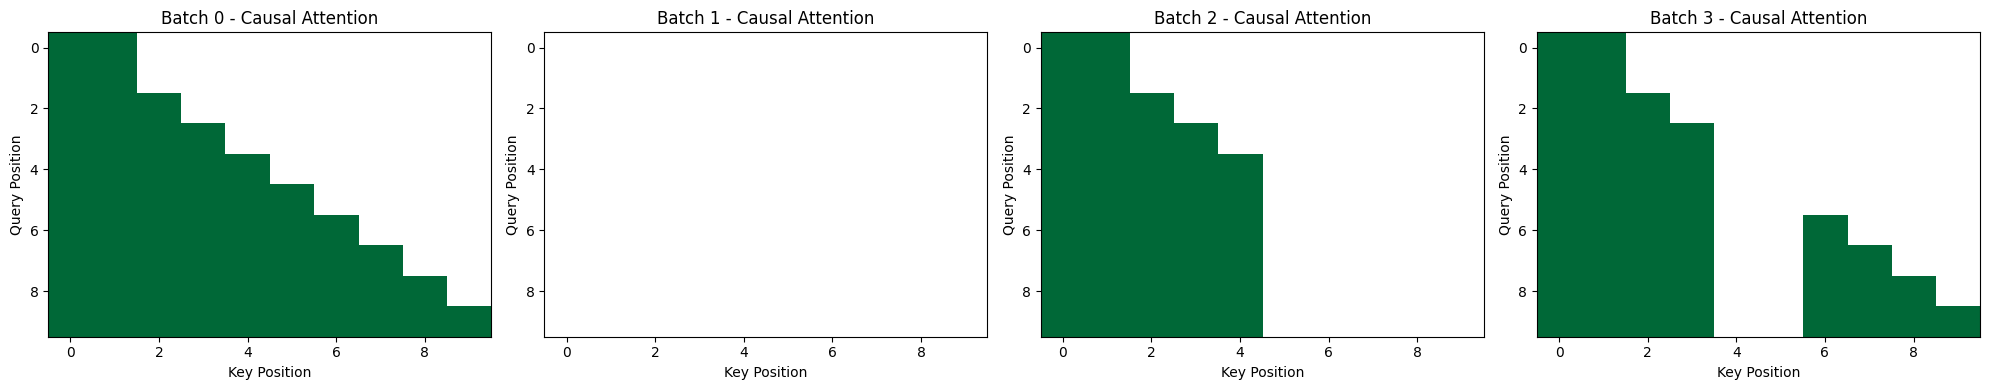

In [133]:
visualize_causal_attn(causal_attn)

In [134]:
# Test with KV cache (simulating generation after prefill)
# First, do a prefill pass
prefill_x = torch.randn(4, 10, vlm_cfg.lm_hidden_dim)
prefill_cos = cos[:, :10, :]
prefill_sin = sin[:, :10, :]
prefill_attention_mask = torch.zeros(4, 10)
prefill_attention_mask[0, :] = 1
prefill_attention_mask[1, :] = 0
prefill_attention_mask[2, :5] = 1
prefill_attention_mask[3, :4] = 1
prefill_attention_mask[3, 6:] = 1

# Create dummy block_kv_cache with 2 image tokens for prefill
prefill_block_kv_cache = {
    'key': torch.randn(4, gqa.n_kv_heads, 2, gqa.head_dim),  # (B, n_kv_heads, T_img_kv=2, head_dim)
    'value': torch.randn(4, gqa.n_kv_heads, 2, gqa.head_dim)  # (B, n_kv_heads, T_img_kv=2, head_dim)
}

# Prefill pass - with block_kv_cache
output_prefill, cache_prefill, additive_mask_prefill, causal_mask_prefill = gqa.forward(
    prefill_x, prefill_cos, prefill_sin, prefill_attention_mask, prefill_block_kv_cache
)

print(f"Prefill output shape: {output_prefill.shape}")
print(f"Prefill cache key shape: {cache_prefill['key'].shape}")
print(f"Prefill cache value shape: {cache_prefill['value'].shape}")

# Now simulate generation - add 1 new token
new_token_x = torch.randn(4, 1, vlm_cfg.lm_hidden_dim)
new_token_cos = cos[:, 10:11, :]  # Position 10
new_token_sin = sin[:, 10:11, :]
# Start with prefill mask and add one more position
new_attention_mask = torch.cat([prefill_attention_mask, torch.ones(4, 1)], dim=1)  # Now we have 11 tokens total

# Generation pass - with cache_prefill (which already contains the image tokens + prefill text tokens)
output_autoregressive, cache_autoregressive, additive_mask_autoregressive, causal_mask_autoregressive = gqa.forward(
    new_token_x, new_token_cos, new_token_sin, new_attention_mask, cache_prefill
)

print(f"\nGeneration output shape: {output_autoregressive.shape}")
print(f"Generation cache key shape: {cache_autoregressive['key'].shape}")
print(f"Generation cache value shape: {cache_autoregressive['value'].shape}")


Prefill output shape: torch.Size([4, 10, 576])
Prefill cache key shape: torch.Size([4, 3, 10, 64])
Prefill cache value shape: torch.Size([4, 3, 10, 64])

Generation output shape: torch.Size([4, 1, 576])
Generation cache key shape: torch.Size([4, 3, 11, 64])
Generation cache value shape: torch.Size([4, 3, 11, 64])


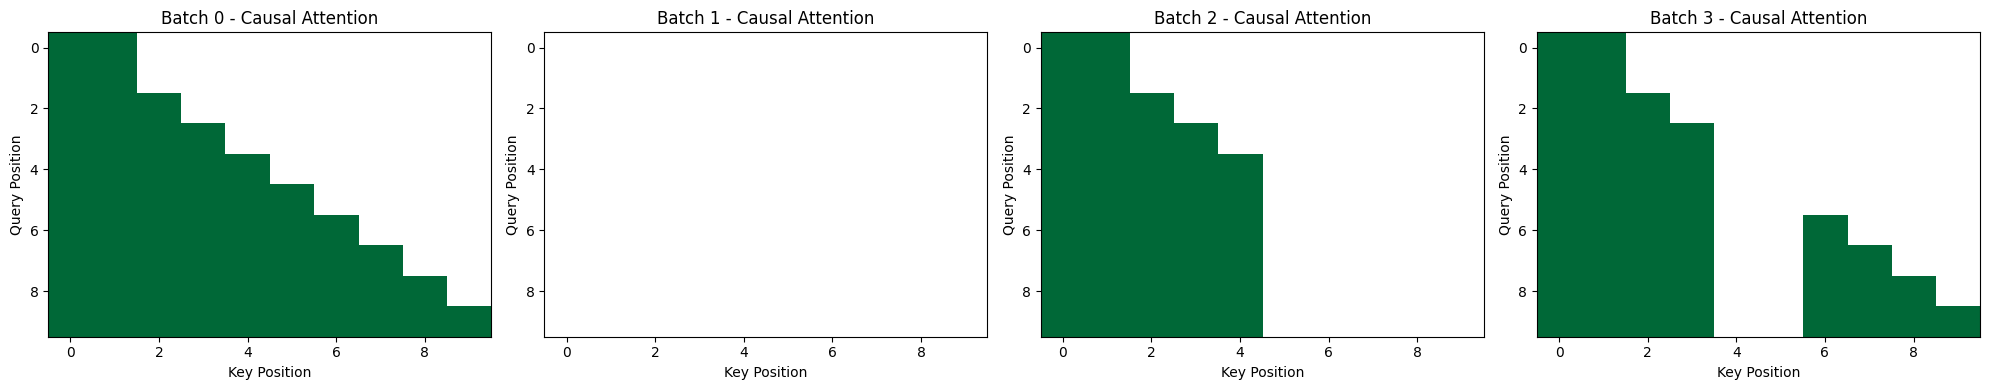

In [135]:
visualize_causal_attn(causal_mask_prefill)

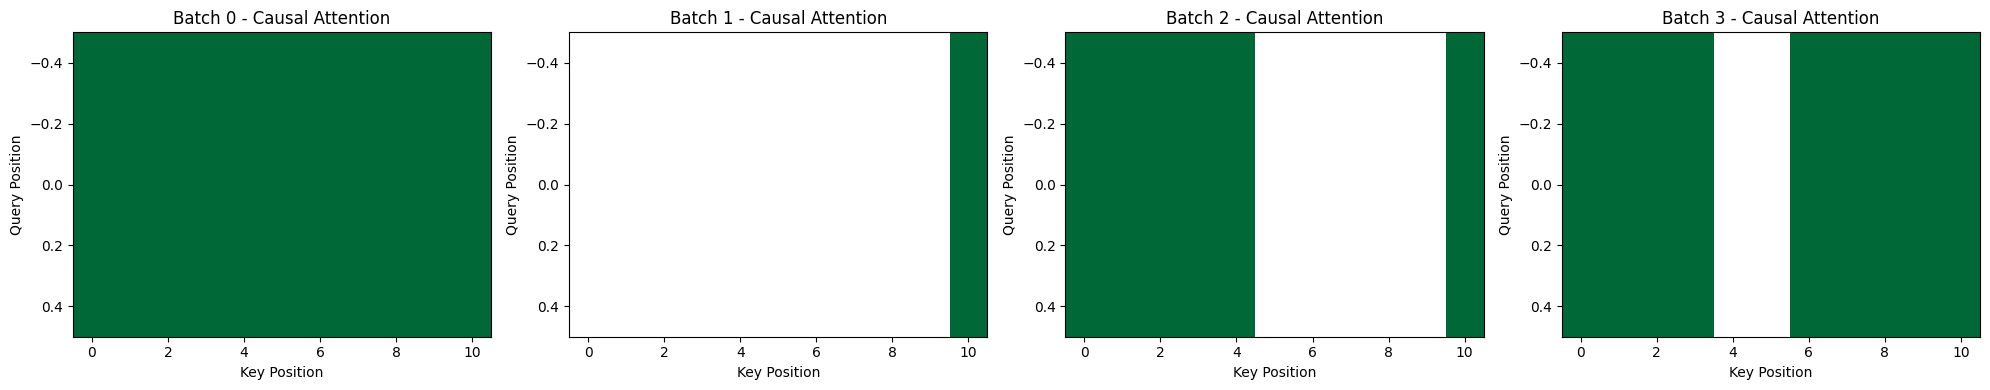

In [136]:
visualize_causal_attn(causal_mask_autoregressive)

## `RightTower` implementation

In [ ]:
class RightTower(LanguageModel):
    def __init__(self, cfg: VLMConfig, *, load_backbone: bool = True, freeze_decoder: bool = False):
        if load_backbone:
            lm = LanguageModel.from_pretrained(cfg)
            super().__init__(cfg)
            self.load_state_dict(lm.state_dict())
            del lm
        else:
            super().__init__(cfg)
        
        if freeze_decoder:
            for p in self.parameters():
                p.requires_grad = False
    
    def forward(
        self,
        x: torch.Tensor,
        attention_mask: torch.Tensor = None,
        kv_cache: list[dict] = None,
        start_pos: int = 0,
    ):
        """
        Forward pass for RightTower (Language Model with image KV cache support).
        
        Args:
            x (Tensor): Input text embeddings of shape (B, T_text, D)
            attention_mask (Tensor, optional): Attention mask of shape (B, T_total) where T_total includes image tokens
            kv_cache (list[dict]): List of dicts containing image KV cache for each block (REQUIRED)
                Each dict has 'key' and 'value' tensors of shape (B, n_kv_heads, T_img, head_dim)
            start_pos (int): Starting position for rotary embeddings (for autoregressive generation)
        
        Returns:
            Tuple[Tensor, list[dict]]: 
                - Output tensor of shape (B, T_text, vocab_size) or (B, T_text, D)
                - Updated KV cache list (including both image and text KV)
        """
        if kv_cache is None:
            raise ValueError("kv_cache must be provided from LeftTower result to RightTower.forward(). It cannot be None.")
        
        B, T_text, _ = x.size()
        
        # Create position_ids for the current text sequence based on start_pos
        current_position_ids = torch.arange(start_pos, start_pos + T_text, device=x.device).unsqueeze(0).expand(B, -1)
        cos, sin = self.rotary_embd(current_position_ids, attention_mask)
        
        # Process through all transformer blocks
        for i, block in enumerate(self.blocks):
            x, kv_cache[i] = block(x, cos, sin, attention_mask, kv_cache[i])
        
        # Final normalization
        x = self.norm(x)
        
        # Compute logits if we are using tokens, otherwise stay in the embedding space
        if self.lm_use_tokens:
            x = self.head(x)
        
        return x, kv_cache

    @torch.inference_mode()
    def generate(self, inputs: torch.Tensor, max_new_tokens: int=20, attention_mask: torch.Tensor=None):
        """
        Generate tokens autoregressively from a given input sequence.

        Args:
            inputs (torch.Tensor): Input tensor containing token indices or embeddings.
                Shape: (batch_size, sequence_length) or (sequence_length,) for a single sequence.
            max_new_tokens (int): Number of new tokens to generate after the input sequence.
            attention_mask (torch.Tensor, optional): Attention mask for the input sequence.
                Shape: (batch_size, sequence_length). 1 for valid tokens, 0 for padding.

        Returns:
            torch.Tensor: The generated sequence, including the original inputs and newly generated tokens.
                Shape: (batch_size, sequence_length + max_new_tokens)
        """
        # Add batch dimension if needed
        if inputs.dim() == 1:
            inputs = inputs.unsqueeze(0)
        generated_outputs = inputs.clone()
        
        # Handle attention mask
        if attention_mask is None:
            # If no mask provided, assume all tokens are valid
            attention_mask = torch.ones_like(inputs, dtype=torch.long)
        elif attention_mask.dim() == 1:
            attention_mask = attention_mask.unsqueeze(0)
        
        # Clone the attention mask so we can extend it during generation
        current_attention_mask = attention_mask.clone()

        prompt_output, kv_cache_list = self.forward(
            generated_outputs, 
            attention_mask=current_attention_mask,
            kv_cache=None,
            start_pos=0
        )
        last_output = prompt_output[:, -1, :]
        
        # count non <pad> area, this is the valid final position ID before autoregressive increment++
        current_token_start_pos = current_attention_mask.sum(dim=1).max().item() - 1

        # Decode Phase with KV cache
        for i in range(max_new_tokens):
            if self.lm_use_tokens:
                # Now the model outputs logits
                next_output = torch.argmax(last_output, dim=-1, keepdim=True)
            else:
                # Now the model outputs embeddings
                next_output = last_output.unsqueeze(1)

            generated_outputs = torch.cat((generated_outputs, next_output), dim=1)
            
            # Extend attention mask for the new token (it's always valid, not padding)
            new_token_mask = torch.ones((current_attention_mask.size(0), 1), 
                                        dtype=current_attention_mask.dtype, 
                                        device=current_attention_mask.device)
            current_attention_mask = torch.cat([current_attention_mask, new_token_mask], dim=1)
            
            # increment pos ID for next token
            current_token_start_pos += 1
            if i == max_new_tokens - 1: 
                break

            decode_step_output, kv_cache_list = self.forward(
                next_output, 
                attention_mask=current_attention_mask,
                kv_cache=kv_cache_list,
                start_pos=current_token_start_pos
            )
            last_output = decode_step_output[:, -1, :] 
    
        return generated_outputs

# 4. DualTowerVLM

## `LeftTower` + `RightTower`

In [ ]:
class LeftTower(VisionLanguageModel):
    def __init__(
        self,
        cfg: VLMConfig,
        *,
        load_backbone: bool = True,
        freeze_vision_encoder: bool = False,
        freeze_modality_projector: bool = False,
        freeze_language_decoder: bool = False,
    ):
        super().__init__(cfg, load_backbone=load_backbone)
        if freeze_vision_encoder:
            for p in self.vision_encoder.parameters():
                p.requires_grad = False
        if freeze_modality_projector:
            for p in self.MP.parameters():
                p.requires_grad = False
        if freeze_language_decoder:
            for p in self.decoder.parameters():
                p.requires_grad = False

    def forward(
        self, 
        input_ids: torch.Tensor, 
        images, 
        attention_mask: torch.Tensor = None,
    ):
        images_tensor = self._process_images(images, input_ids.device)
        token_embd = self.decoder.token_embedding(input_ids)

        if images_tensor is not None:
            image_embd = self.vision_encoder(images_tensor)
            image_embd = self.MP(image_embd)
            token_embd = self._replace_img_tokens_with_embd(input_ids, token_embd, image_embd)
        
        _, kv_cache = self.decoder(token_embd, attention_mask=attention_mask)
        
        return None, kv_cache

In [ ]:
class RightTower(LanguageModel):
    def __init__(self, cfg: VLMConfig, *, load_backbone: bool = True, freeze_decoder: bool = False):
        if load_backbone:
            lm = LanguageModel.from_pretrained(cfg)
            super().__init__(cfg)
            self.load_state_dict(lm.state_dict())
            del lm
        else:
            super().__init__(cfg)
        
        if freeze_decoder:
            for p in self.parameters():
                p.requires_grad = False
    
    def forward(
        self,
        x: torch.Tensor,
        attention_mask: torch.Tensor = None,
        kv_cache: list[dict] = None,
        start_pos: int = 0,
    ):
        """
        Forward pass for RightTower (Language Model with image KV cache support).
        
        Args:
            x (Tensor): Input text embeddings of shape (B, T_text, D)
            attention_mask (Tensor, optional): Attention mask of shape (B, T_total) where T_total includes image tokens
            kv_cache (list[dict]): List of dicts containing image KV cache for each block (REQUIRED)
                Each dict has 'key' and 'value' tensors of shape (B, n_kv_heads, T_img, head_dim)
            start_pos (int): Starting position for rotary embeddings (for autoregressive generation)
        
        Returns:
            Tuple[Tensor, list[dict]]: 
                - Output tensor of shape (B, T_text, vocab_size) or (B, T_text, D)
                - Updated KV cache list (including both image and text KV)
        """
        if kv_cache is None:
            raise ValueError("kv_cache must be provided from LeftTower result to RightTower.forward(). It cannot be None.")
        
        # TODO: see if we need this or no
        # if self.lm_use_tokens:
        #     x = self.token_embedding(x)
        
        B, T_text, _ = x.size()
        
        # Create position_ids for the current text sequence based on start_pos
        current_position_ids = torch.arange(start_pos, start_pos + T_text, device=x.device).unsqueeze(0).expand(B, -1)
        cos, sin = self.rotary_embd(current_position_ids, attention_mask)
        
        # Process through all transformer blocks
        for i, block in enumerate(self.blocks):
            x, kv_cache[i] = block(x, cos, sin, attention_mask, kv_cache[i])
        
        # Final normalization
        x = self.norm(x)
        
        # Compute logits if we are using tokens, otherwise stay in the embedding space
        if self.lm_use_tokens:
            x = self.head(x)
        
        return x, kv_cache

    @torch.inference_mode()
    def generate(self, inputs: torch.Tensor, max_new_tokens: int=20, attention_mask: torch.Tensor=None):
        """
        Generate tokens autoregressively from a given input sequence.

        Args:
            inputs (torch.Tensor): Input tensor containing token indices or embeddings.
                Shape: (batch_size, sequence_length) or (sequence_length,) for a single sequence.
            max_new_tokens (int): Number of new tokens to generate after the input sequence.
            attention_mask (torch.Tensor, optional): Attention mask for the input sequence.
                Shape: (batch_size, sequence_length). 1 for valid tokens, 0 for padding.

        Returns:
            torch.Tensor: The generated sequence, including the original inputs and newly generated tokens.
                Shape: (batch_size, sequence_length + max_new_tokens)
        """
        # Add batch dimension if needed
        if inputs.dim() == 1:
            inputs = inputs.unsqueeze(0)
        generated_outputs = inputs.clone()
        
        # Handle attention mask
        if attention_mask is None:
            # If no mask provided, assume all tokens are valid
            attention_mask = torch.ones_like(inputs, dtype=torch.long)
        elif attention_mask.dim() == 1:
            attention_mask = attention_mask.unsqueeze(0)
        
        # Clone the attention mask so we can extend it during generation
        current_attention_mask = attention_mask.clone()

        prompt_output, kv_cache_list = self.forward(
            generated_outputs, 
            attention_mask=current_attention_mask,
            kv_cache=None,
            start_pos=0
        )
        last_output = prompt_output[:, -1, :]
        
        # count non <pad> area, this is the valid final position ID before autoregressive increment++
        current_token_start_pos = current_attention_mask.sum(dim=1).max().item() - 1

        # Decode Phase with KV cache
        for i in range(max_new_tokens):
            if self.lm_use_tokens:
                # Now the model outputs logits
                next_output = torch.argmax(last_output, dim=-1, keepdim=True)
            else:
                # Now the model outputs embeddings
                next_output = last_output.unsqueeze(1)

            generated_outputs = torch.cat((generated_outputs, next_output), dim=1)
            
            # Extend attention mask for the new token (it's always valid, not padding)
            new_token_mask = torch.ones((current_attention_mask.size(0), 1), 
                                        dtype=current_attention_mask.dtype, 
                                        device=current_attention_mask.device)
            current_attention_mask = torch.cat([current_attention_mask, new_token_mask], dim=1)
            
            # increment pos ID for next token
            current_token_start_pos += 1
            if i == max_new_tokens - 1: 
                break

            decode_step_output, kv_cache_list = self.forward(
                next_output, 
                attention_mask=current_attention_mask,
                kv_cache=kv_cache_list,
                start_pos=current_token_start_pos
            )
            last_output = decode_step_output[:, -1, :] 
    
        return generated_outputs

## `DualTowerVLM` Implementation

In [ ]:
class DualTowerVLM(nn.Module):
    def __init__(
        self,
        cfg: VLMConfig,
        *,
        load_backbone: bool = True,
        freeze_left_vision: bool = False,
        freeze_left_projector: bool = False,
        freeze_left_decoder: bool = False,
        freeze_right_decoder: bool = False,
    ):
        super().__init__()
        self.cfg = cfg
        self.left_tower = LeftTower(
            cfg,
            load_backbone=load_backbone,
            freeze_vision_encoder=freeze_left_vision,
            freeze_modality_projector=freeze_left_projector,
            freeze_language_decoder=freeze_left_decoder,
        )
        self.right_tower = RightTower(
            cfg,
            load_backbone=load_backbone,
            freeze_decoder=freeze_right_decoder,
        )
        self.tokenizer = self.left_tower.tokenizer
    def forward(
        self,
        input_ids: torch.Tensor,
        images,
        last_img_idx: torch.Tensor = None,
        attention_mask: torch.Tensor = None,
        targets: torch.Tensor = None
    ):
        B = input_ids.size(0)
        device = input_ids.device

        # Process left tower to grab kv_cache
        _, kv_cache = self.left_tower(
            input_ids= input_ids[:, :last_img_idx + 1],
            images=images,
            attention_mask=attention_mask[:, :last_img_idx + 1],
        )

        # Process to right tower and use left's kv_cache
        logits, _ = self.right_tower(
            x=input_ids,
            attention_mask=attention_mask,
            kv_cache=kv_cache,
            start_pos=0
        )

        # Loss calculation (if any)
        loss = None
        if targets is not None:
            logits = self.right_tower.head(logits)
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1), ignore_index=-100)
        
        return logits, loss
    
    @torch.inference_mode()
    def generate(
        self,
        input_ids: torch.Tensor,
        images,
        last_img_idx: torch.Tensor = None,
        attention_mask: torch.Tensor = None,
        max_new_tokens: int = 50,
        top_k: int = 50,
        top_p: float = 0.9,
        temperature: float = 0.5,
        greedy: bool = False,
    ):
        """
        Generate tokens autoregressively using the dual tower architecture.
        
        Args:
            input_ids (torch.Tensor): Input token IDs of shape (B, T)
            images: Images to process (can be list or tensor)
            last_img_idx (torch.Tensor): Index of the last image token in each sequence
            attention_mask (torch.Tensor, optional): Attention mask of shape (B, T)
            max_new_tokens (int): Number of new tokens to generate
            top_k (int): Top-k filtering parameter for sampling
            top_p (float): Top-p (nucleus) filtering parameter for sampling
            temperature (float): Temperature for sampling (higher = more random)
            greedy (bool): If True, use greedy decoding (argmax), otherwise use sampling
        
        Returns:
            torch.Tensor: Generated token IDs of shape (B, max_new_tokens)
        """
        B = input_ids.size(0)
        device = input_ids.device
        
        # Add batch dimension if needed
        if input_ids.dim() == 1:
            input_ids = input_ids.unsqueeze(0)
            B = 1
        
        # Handle attention mask
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids, dtype=torch.long)
        elif attention_mask.dim() == 1:
            attention_mask = attention_mask.unsqueeze(0)
        
        # Process left tower to get image KV cache
        _, kv_cache = self.left_tower(
            input_ids=input_ids[:, :last_img_idx + 1],
            images=images,
            attention_mask=attention_mask[:, :last_img_idx + 1],
        )
        
        # Prefill phase: process the FULL sequence with image KV cache
        # The right tower will internally handle replacing image K/V with cached values
        # See modified GQA implementation above for this `LanguageModelGroupedQueryAttention`

        # TODO: below token embedding code is the bypass attempt on self.cfg.lm_use_token, future work may include `if self.cfg.lm_use_tokens` for better conditional in various cases.
        full_embd = self.right_tower.token_embedding(input_ids)
        prompt_output, kv_cache = self.right_tower.forward(
            x=full_embd,
            attention_mask=attention_mask,
            kv_cache=kv_cache,
            start_pos=0  # we start prefill from pos 0
        )
        
        last_output = prompt_output[:, -1, :]
        
        # Get logits from the last token output
        if not self.right_tower.lm_use_tokens:
            current_logits = self.right_tower.head(last_output)
        else:
            current_logits = last_output
        
        # Track the current total sequence length for position tracking
        current_token_start_pos = attention_mask.sum(dim=1).max().item() - 1
        
        newly_generated_ids_list = []
        current_attention_mask = attention_mask.clone()
        
        # Autoregressive generation loop
        for _ in range(max_new_tokens):
            # Sample next token
            if greedy:
                next_token_id = torch.argmax(current_logits, dim=-1, keepdim=True)
            else:
                filtered_logits = top_k_top_p_filtering(current_logits, top_k=top_k, top_p=top_p)
                probs = torch.softmax(filtered_logits / temperature, dim=-1)
                next_token_id = torch.multinomial(probs, num_samples=1)
            
            newly_generated_ids_list.append(next_token_id)
            
            # Embed the newly generated token
            next_token_embed = self.right_tower.token_embedding(next_token_id)  # [B, 1, D_lm]
            
            # The start_pos for the new token is the current total sequence length *before* adding this new token
            current_token_start_pos += 1
            
            # Update attention mask
            new_token_mask = torch.ones((B, 1), 
                                        dtype=current_attention_mask.dtype, 
                                        device=device)
            current_attention_mask = torch.cat([current_attention_mask, new_token_mask], dim=1)
            
            # With KV cache: only process the new token
            decode_step_output, kv_cache = self.right_tower.forward(
                x=next_token_embed,
                attention_mask=current_attention_mask,
                kv_cache=kv_cache,
                start_pos=current_token_start_pos
            )
            
            last_token_output = decode_step_output[:, -1, :]
            
            # Apply head to get logits (if model is in embedding mode)
            if not self.right_tower.lm_use_tokens:
                current_logits = self.right_tower.head(last_token_output)
            else:
                current_logits = last_token_output
        
        # Concatenate all generated tokens
        if not newly_generated_ids_list:
            return torch.empty((B, 0), dtype=torch.long, device=device)
        
        generated_ids = torch.cat(newly_generated_ids_list, dim=1)
        
        # Post-process to handle EOS token
        if self.tokenizer.eos_token_id is not None and generated_ids.numel() > 0:
            seq_len = generated_ids.size(1)
            eos_mask = (generated_ids == self.tokenizer.eos_token_id)  # Create a boolean mask for EOS tokens
            col_indices_for_min = torch.arange(seq_len, device=device)  # Create column indices [0, 1, ..., seq_len-1]
            
            # In eos_mask, mark positions with actual col_idx, others with a large number
            masked_col_indices = torch.where(eos_mask, col_indices_for_min.unsqueeze(0).expand_as(generated_ids), seq_len + 1)
            first_eos_indices_values = torch.min(masked_col_indices, dim=1).values
            
            # Clamp values to seq_len (if no EOS found, min will be seq_len + 1, clamp brings it to seq_len)
            actual_first_eos_indices = torch.clamp(first_eos_indices_values, max=seq_len)
            
            # Create column indices for comparison, shape [batch_size, seq_len]
            col_indices_for_comparison = torch.arange(seq_len, device=device).unsqueeze(0).expand_as(generated_ids)
            
            # Tokens are replaced if their column index is greater than the index of the first EOS token
            replace_mask = col_indices_for_comparison > actual_first_eos_indices.unsqueeze(1)
            
            generated_ids[replace_mask] = self.tokenizer.eos_token_id
        
        return generated_ids